In [1]:
! nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-4996e117-c4db-33eb-ede9-cca5e93aef5b)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Prepare dataset

In [3]:
%%shell
gdown -O ./training_hr_images.zip 'https://drive.google.com/uc?export=download&id=1bIowNL2X6zqfnmfcxqX3oPh2GIR9lxnr'
gdown -O ./testing_lr_images.zip 'https://drive.google.com/uc?export=download&id=1B7QlA1HPH7zMENuYXDxlbzgNLbJqS1zJ'

Downloading...
From: https://drive.google.com/uc?export=download&id=1bIowNL2X6zqfnmfcxqX3oPh2GIR9lxnr
To: /content/training_hr_images.zip
61.5MB [00:01, 60.4MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1B7QlA1HPH7zMENuYXDxlbzgNLbJqS1zJ
To: /content/testing_lr_images.zip
100% 746k/746k [00:00<00:00, 49.6MB/s]


In [4]:
%%shell
unzip ./training_hr_images.zip -d ./data/
unzip ./testing_lr_images.zip -d ./data/

Archive:  ./training_hr_images.zip
  inflating: ./data/training_hr_images/100075.png  
  inflating: ./data/training_hr_images/100080.png  
  inflating: ./data/training_hr_images/100098.png  
  inflating: ./data/training_hr_images/103041.png  
  inflating: ./data/training_hr_images/104022.png  
  inflating: ./data/training_hr_images/105019.png  
  inflating: ./data/training_hr_images/105053.png  
  inflating: ./data/training_hr_images/106020.png  
  inflating: ./data/training_hr_images/106025.png  
  inflating: ./data/training_hr_images/108041.png  
  inflating: ./data/training_hr_images/108073.png  
  inflating: ./data/training_hr_images/109034.png  
  inflating: ./data/training_hr_images/112082.png  
  inflating: ./data/training_hr_images/113009.png  
  inflating: ./data/training_hr_images/113016.png  
  inflating: ./data/training_hr_images/113044.png  
  inflating: ./data/training_hr_images/117054.png  
  inflating: ./data/training_hr_images/118020.png  
  inflating: ./data/training_

In [5]:
%%shell
rm -rf ./sample_data ./training_hr_images.zip ./testing_lr_images.zip

## Import packages

In [7]:
import os
import os.path as osp
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage import io
import sklearn.model_selection
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import time
import copy

from edsr import EDSR

## Data preprocessing

### Analysize testing data

In [8]:
test_info = []

for img_name in tqdm(os.listdir('./data/testing_lr_images')):
    img_path = f'./data/testing_lr_images/{img_name}'
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    test_info.append(dict(name=img_name, height=h, width=w, ratio=w / h))

print()
print(len(test_info))
print(test_info[0])

100%|██████████| 14/14 [00:00<00:00, 412.95it/s]


14
{'name': '11.png', 'height': 120, 'width': 83, 'ratio': 0.6916666666666667}


In [9]:
test_info = sorted(test_info, key=lambda x: x['ratio'])
print(*test_info, sep='\n')

{'name': '11.png', 'height': 120, 'width': 83, 'ratio': 0.6916666666666667}
{'name': '09.png', 'height': 218, 'width': 176, 'ratio': 0.8073394495412844}
{'name': '03.png', 'height': 92, 'width': 92, 'ratio': 1.0}
{'name': '01.png', 'height': 170, 'width': 170, 'ratio': 1.0}
{'name': '02.png', 'height': 170, 'width': 170, 'ratio': 1.0}
{'name': '07.png', 'height': 170, 'width': 170, 'ratio': 1.0}
{'name': '13.png', 'height': 170, 'width': 170, 'ratio': 1.0}
{'name': '06.png', 'height': 160, 'width': 166, 'ratio': 1.0375}
{'name': '05.png', 'height': 96, 'width': 117, 'ratio': 1.21875}
{'name': '10.png', 'height': 96, 'width': 117, 'ratio': 1.21875}
{'name': '00.png', 'height': 192, 'width': 240, 'ratio': 1.25}
{'name': '12.png', 'height': 120, 'width': 166, 'ratio': 1.3833333333333333}
{'name': '08.png', 'height': 130, 'width': 195, 'ratio': 1.5}
{'name': '04.png', 'height': 170, 'width': 256, 'ratio': 1.5058823529411764}


### Analysize training data

In [10]:
train_info = []

for img_name in tqdm(os.listdir('./data/training_hr_images')):
    img_path = f'./data/training_hr_images/{img_name}'
    img = cv2.imread(img_path)
    h, w = img.shape[:2]
    train_info.append(dict(name=img_name, height=h, width=w, ratio=w / h))

print()
print(len(train_info))
print(train_info[0])

100%|██████████| 291/291 [00:01<00:00, 273.79it/s]


291
{'name': 't58.png', 'height': 202, 'width': 219, 'ratio': 1.0841584158415842}


In [11]:
train_info = sorted(train_info, key=lambda x: x['ratio'])
print(*train_info[:10], sep='\n')
print(*train_info[-20:], sep='\n')

{'name': 'tt15.png', 'height': 330, 'width': 218, 'ratio': 0.6606060606060606}
{'name': '225017.png', 'height': 481, 'width': 321, 'ratio': 0.6673596673596673}
{'name': '26031.png', 'height': 481, 'width': 321, 'ratio': 0.6673596673596673}
{'name': '48055.png', 'height': 481, 'width': 321, 'ratio': 0.6673596673596673}
{'name': '23025.png', 'height': 481, 'width': 321, 'ratio': 0.6673596673596673}
{'name': '388016.png', 'height': 481, 'width': 321, 'ratio': 0.6673596673596673}
{'name': '15088.png', 'height': 481, 'width': 321, 'ratio': 0.6673596673596673}
{'name': '246053.png', 'height': 481, 'width': 321, 'ratio': 0.6673596673596673}
{'name': '301007.png', 'height': 481, 'width': 321, 'ratio': 0.6673596673596673}
{'name': '311081.png', 'height': 481, 'width': 321, 'ratio': 0.6673596673596673}
{'name': '2092.png', 'height': 321, 'width': 481, 'ratio': 1.4984423676012462}
{'name': 't39.png', 'height': 209, 'width': 314, 'ratio': 1.5023923444976077}
{'name': 't34.png', 'height': 121, 'wid

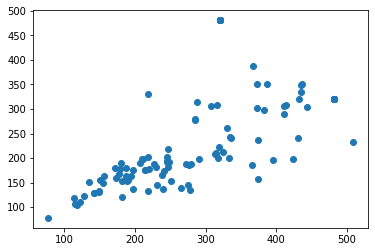

In [12]:
x = [image['width'] for image in train_info]
y = [image['height'] for image in train_info]

plt.scatter(x, y)

### Data cleaning

In [13]:
# Remove data with large aspect ratio
#new_train = [data for data in train_info if data['ratio'] < 1.6]
#print(len(new_train))

In [14]:
new_train = train_info.copy()

new_train = sorted(new_train, key=lambda x: x['height'])
print(*new_train[:5], sep='\n')
print(*new_train[-5:], sep='\n')
print()
new_train = sorted(new_train, key=lambda x: x['width'])
print(*new_train[:5], sep='\n')
print(*new_train[-5:], sep='\n')

{'name': 't20.png', 'height': 78, 'width': 78, 'ratio': 1.0}
{'name': 't9.png', 'height': 105, 'width': 119, 'ratio': 1.1333333333333333}
{'name': 't24.png', 'height': 107, 'width': 116, 'ratio': 1.0841121495327102}
{'name': 't21.png', 'height': 111, 'width': 123, 'ratio': 1.1081081081081081}
{'name': 't12.png', 'height': 119, 'width': 114, 'ratio': 0.957983193277311}
{'name': '187029.png', 'height': 481, 'width': 321, 'ratio': 0.6673596673596673}
{'name': '368078.png', 'height': 481, 'width': 321, 'ratio': 0.6673596673596673}
{'name': '61086.png', 'height': 481, 'width': 321, 'ratio': 0.6673596673596673}
{'name': '246016.png', 'height': 481, 'width': 321, 'ratio': 0.6673596673596673}
{'name': '181091.png', 'height': 481, 'width': 321, 'ratio': 0.6673596673596673}

{'name': 't20.png', 'height': 78, 'width': 78, 'ratio': 1.0}
{'name': 't12.png', 'height': 119, 'width': 114, 'ratio': 0.957983193277311}
{'name': 't24.png', 'height': 107, 'width': 116, 'ratio': 1.0841121495327102}
{'name':

In [15]:
# Remove data with small height/width
print(len(new_train))
new_train = [
    data for data in new_train if \
    500 > data['height'] > 120 and \
    500 > data['width'] > 120
]
print(len(new_train))

291
285


### Resize

In [16]:
# Make max_h, max_w divisible by 3
max_h = max_w = -1
for data in new_train:
    if data['height'] > max_h:
        max_h = data['height']
    if data['width'] > max_w:
        max_w = data['width']

max_h = (max_h // 3 + 1) * 3
max_w = (max_w // 3 + 1) * 3

print(f'Max height: {max_h}\nMax width: {max_w}')

Max height: 483
Max width: 483


In [17]:
hr_h = max_h
hr_w = max_w
lr_h = max_h // 3
lr_w = max_w // 3

In [48]:
! mkdir ./data/train
! mkdir ./data/train/3x
! mkdir ./data/train/1x
! mkdir ./data/train/3x_pseudo

mkdir: cannot create directory ‘./data/train’: File exists
mkdir: cannot create directory ‘./data/train/3x’: File exists
mkdir: cannot create directory ‘./data/train/1x’: File exists
mkdir: cannot create directory ‘./data/train/3x_pseudo’: File exists


In [49]:
# Pad images to same scale of HR images
for data in tqdm(new_train):
    img_name = data['name']
    img_path = f'./data/training_hr_images/{img_name}'
    img = cv2.imread(img_path)

    img_h, img_w = img.shape[:2]
    pad_h = hr_h - img_h
    pad_w = hr_w - img_w

    new_img = np.pad(
        img,
        [
            (pad_h // 2, pad_h - pad_h // 2),
            (pad_w // 2, pad_w - pad_w // 2),
            (0, 0)
        ],
        'reflect')
    assert new_img.shape[0] == hr_h and new_img.shape[1] == hr_w

    # Store new image
    new_path = f'./data/train/3x/{img_name}'
    cv2.imwrite(new_path, new_img)

100%|██████████| 285/285 [00:04<00:00, 57.65it/s]


In [50]:
# Resize HR images to LR images
img_id = 0
for data in tqdm(new_train):
    img_name = data['name']
    img_path = f'./data/train/3x/{img_name}'
    img = cv2.imread(img_path)

    new_img = cv2.resize(img, (lr_w, lr_h), cv2.INTER_AREA)
    cv2.imwrite(f'./data/train/1x/{img_name}', new_img)

100%|██████████| 285/285 [00:02<00:00, 121.73it/s]


In [25]:
# Create pseudo HR images by interpolate on LR images
for img_name in tqdm(os.listdir('./data/train/1x_area')):
    img_path = f'./data/train/1x_area/{img_name}'
    img = cv2.imread(img_path)

    new_img = cv2.resize(img, (hr_w, hr_h), cv2.INTER_LANCZOS4)
    #new_img = cv2.resize(img, (hr_w, hr_h), cv2.INTER_CUBIC)

    new_path = f'./data/train/3x_pseudo/{img_name}'
    cv2.imwrite(new_path, new_img)

100%|██████████| 285/285 [00:03<00:00, 72.36it/s]


### Visiualization

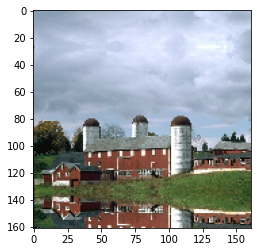

In [54]:
plt.imshow(cv2.imread('./data/train/1x/97017.png')[:,:,::-1])

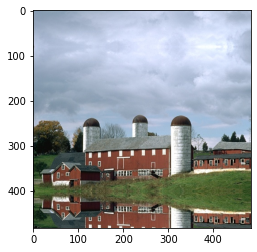

In [55]:
plt.imshow(cv2.imread('./data/train/3x/97017.png')[:,:,::-1])

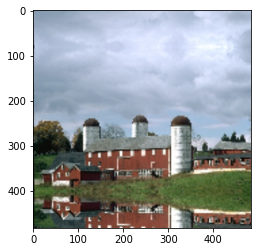

In [56]:
plt.imshow(cv2.imread('./data/train/3x_pseudo/97017.png')[:,:,::-1])

## Main

In [57]:
class SRDataset(Dataset):
    def __init__(self, data_list, root_dir, transform=None, is_train=True):
        self.data_list = data_list
        self.root_dir = root_dir
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.data_list)
    
    def randomCrop(self, sample, scale=(0.75, 0.75), prob=1.0):
        if np.random.rand(1) >= prob:
            return sample

        assert isinstance(scale, (float, tuple))
        if isinstance(scale, float):
            scale = (scale, scale)
        else:
            assert len(scale) == 2
            scale = scale
    
        data, target, pseudo = sample['data'], sample['target'], sample['pseudo']

        h, w = data.shape[:2]
        new_h = int(h * scale[0])
        new_w = int(w * scale[1])

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        data = data[top: top + new_h, left: left + new_w]
        target = target[top * 3: (top + new_h) * 3, left * 3: (left + new_w) * 3]
        pseudo = pseudo[top * 3: (top + new_h) * 3, left * 3: (left + new_w) * 3]

        return dict(data=data, target=target, pseudo=pseudo)

    def cutBlur(self, sample, cut_ratio=(0.25, 0.25), prob=1.0):
        if np.random.rand(1) >= prob:
            return sample

        assert isinstance(cut_ratio, (float, tuple))
        if isinstance(cut_ratio, float):
            cut_ratio = (cut_ratio, cut_ratio)
        else:
            assert len(cut_ratio) == 2
            cut_ratio = cut_ratio

        data, target, pseudo = sample['data'], sample['target'], sample['pseudo']

        h, w = target.shape[:2]
        cut_h = int(h * cut_ratio[0])
        cut_w = int(w * cut_ratio[1])

        top = np.random.randint(0, h - cut_h)
        left = np.random.randint(0, w - cut_w)

        if np.random.random() > 0.5:
            target[top: top + cut_h, left: left + cut_w] = \
            pseudo[top: top + cut_h, left: left + cut_w]

        return dict(data=data, target=target, pseudo=pseudo)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = f'{self.root_dir}/1x/{self.data_list[idx]}'
        data = io.imread(img_name)
        img_name = f'{self.root_dir}/3x/{self.data_list[idx]}'
        target = io.imread(img_name)
        img_name = f'{self.root_dir}/3x_pseudo/{self.data_list[idx]}'
        pseudo = io.imread(img_name)

        sample = dict(data=data, target=target, pseudo=pseudo)
        if self.is_train:
            sample = self.randomCrop(sample, scale=0.5)
            #sample = self.cutBlur(sample)
        if self.transform:
            sample['data'] = self.transform(sample['data'])
            sample['target'] = self.transform(sample['target'])
            sample['pseudo'] = self.transform(sample['pseudo'])
        
        return sample


In [60]:
# Split dataset
train_list, val_list = sklearn.model_selection.train_test_split(
    os.listdir('./data/train/3x'), test_size=0.2, random_state=42)
print(len(train_list), len(val_list))

228 57


In [61]:
FLAGS = {}
FLAGS['batch_size'] = 32
FLAGS['num_workers'] = 8

In [62]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
data_transforms = dict(
    train=transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]),
    val=transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]))

datasets = dict(
    train=SRDataset(
        data_list=train_list,
        root_dir='./data/train',
        transform=data_transforms['train'],
        is_train=True),
    val=SRDataset(
        data_list=val_list,
        root_dir='./data/train',
        transform=data_transforms['val'],
        is_train=False))

dataloaders = dict(
    train=DataLoader(
        datasets['train'],
        batch_size=FLAGS['batch_size'],
        shuffle=True,
        num_workers=FLAGS['num_workers'],
        drop_last=True),
    val=DataLoader(
        datasets['val'],
        batch_size=FLAGS['batch_size'],
        shuffle=False,
        num_workers=FLAGS['num_workers'],
        drop_last=False))

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
n_batches = {x: dataset_sizes[x] // FLAGS['batch_size'] for x in ['train', 'val']}

In [68]:
def show_data_batch(sample_batched):
    data_batched, target_batched = \
        sample_batched['data'], sample_batched['target']
    batch_size = len(sample_batched)
    grid = torchvision.utils.make_grid(data_batched)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [66]:
batch_data = iter(dataloaders['train']).next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


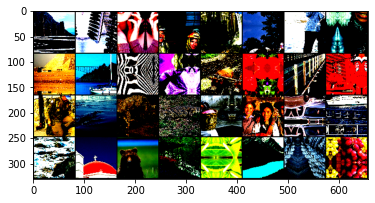

In [69]:
show_data_batch(batch_data)

In [77]:
def train_model(model, criterion, optimizer, num_epochs=25, start=0, scheduler=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100000000000000.0
    best_epoch = -1

    for epoch in range(num_epochs):
        print(f'Epoch {start + epoch + 1}/{start + num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            # Iterate over data
            for x, samples in enumerate(dataloaders[phase]):
                inputs, target = samples['data'], samples['target']
                inputs = inputs.to(device)
                target = target.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, target)

                    # Backward only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item()
                print(f'Batch {x + 1:>4d}/{n_batches[phase]:<4d} Loss: {loss.item() / inputs.size(0):.6f}')

            if scheduler is not None and phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            print(f'Stage: {phase} Loss: {epoch_loss:.6f} Duration: {time.time() - since:.0f}s')

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_epoch = start + epoch + 1
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(
                    dict(
                        name='EDSR',
                        epoch=start + epoch + 1,
                        model_state_dict=best_model_wts,
                        optimizer_state_dict=optimizer.state_dict()),
                    f'./drive/MyDrive/edsr/best_ckpt_epoch_{start + epoch + 1}.pth')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60}m {time_elapsed % 60:.0f}s')
    print(f'Best epoch: {best_epoch} Best val loss: {best_loss:.6f}')

    # Load best model weights (need?)
    model.load_state_dict(best_model_wts)
    return model

In [78]:
class L1_Charbonnier(nn.Module):
    """L1 Charbonnierloss."""
    def __init__(self):
        super(L1_Charbonnier, self).__init__()
        self.eps = 1e-3

    def forward(self, X, Y):
        diff = torch.add(X, -Y)
        error = torch.sqrt( diff * diff + self.eps )
        loss = torch.sum(error)
        return loss

In [79]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [83]:
model = EDSR(scale=3)
model = model.to(device)
criterion = L1_Charbonnier()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.001)

In [84]:
model = train_model(model, criterion, optimizer, num_epochs=100, start=0)

Epoch 1/100
----------
Batch    1/7    Loss: 197631.484375
Batch    2/7    Loss: 107219.687500
Batch    3/7    Loss: 99311.468750
Batch    4/7    Loss: 67060.492188
Batch    5/7    Loss: 74694.046875
Batch    6/7    Loss: 72236.195312
Batch    7/7    Loss: 60644.218750
Stage: train Loss: 95269.837719 Duration: 6s
Batch    1/1    Loss: 240334.281250
Batch    2/1    Loss: 253850.680000
Stage: val Loss: 246262.526316 Duration: 9s
Epoch 2/100
----------
Batch    1/7    Loss: 61071.539062
Batch    2/7    Loss: 52589.562500
Batch    3/7    Loss: 52562.796875
Batch    4/7    Loss: 51262.875000
Batch    5/7    Loss: 40834.589844
Batch    6/7    Loss: 45001.039062
Batch    7/7    Loss: 43954.730469
Stage: train Loss: 48740.650219 Duration: 15s
Batch    1/1    Loss: 166103.250000
Batch    2/1    Loss: 178312.640000
Stage: val Loss: 171458.245614 Duration: 18s
Epoch 3/100
----------
Batch    1/7    Loss: 41901.519531
Batch    2/7    Loss: 46030.277344
Batch    3/7    Loss: 41055.500000
Batch    4


### Validation

In [85]:
print(val_list)

['187003.png', 't63.png', '35008.png', '277095.png', 't18.png', '95006.png', '188005.png', '155060.png', 't13.png', 't14.png', '163062.png', '323016.png', 'tt9.png', '198054.png', '103041.png', 't29.png', 't50.png', '372047.png', '97017.png', '353013.png', '67079.png', 't42.png', '187071.png', '249061.png', '66039.png', '216053.png', '286092.png', 't55.png', '246016.png', '56028.png', '65074.png', '189003.png', '183087.png', 't54.png', 'tt25.png', '24004.png', '90076.png', '124084.png', 't4.png', '66075.png', 'tt13.png', '317080.png', '41004.png', '122048.png', '25098.png', '33066.png', 't47.png', 'tt23.png', 't8.png', '196015.png', 't22.png', '20008.png', '113044.png', '207056.png', '108073.png', '41025.png', '61086.png']


In [109]:
with torch.no_grad():
    total = 0
    for img_name in tqdm(val_list):
        img_3x = cv2.imread(f'./data/training_hr_images/{img_name}')
        img_h, img_w = img_3x.shape[:2]
        pad_h = (img_h // 3 + 1) * 3 - img_h
        pad_w = (img_w // 3 + 1) * 3 - img_w
        img_3x = np.pad(
            img_3x,
            [
                (pad_h // 2, pad_h - pad_h // 2),
                (pad_w // 2, pad_w - pad_w // 2),
                (0, 0)
            ],
            'reflect')
        img_h, img_w = img_3x.shape[:2]
        img_1x = cv2.resize(img_3x, (img_w // 3, img_h // 3), cv2.INTER_AREA)

        input = data_transforms['val'](img_1x[:,:,::-1]).unsqueeze(0).to(device)
        output = model(input)
        img_out = output.squeeze(0).cpu().numpy()
        img_out = np.transpose(img_out, (1, 2, 0))
        img_out = img_out * std + mean
        img_out = img_out.clip(min=0, max=1)
        plt.imsave('./v.png', img_out)
        
        d = cv2.PSNR(cv2.imread('./v.png'), img_3x)
        total += d

    print()
    print(total / len(val_list))

100%|██████████| 57/57 [00:06<00:00,  8.26it/s]


25.939722886730245


### Test

In [86]:
TEST_DIR = './data/testing_lr_images'
OUTPUT_DIR = './drive/MyDrive/SR_output'


model.eval()
with torch.no_grad():
    for img_name in tqdm(os.listdir(TEST_DIR)):
        img_pth = f'{TEST_DIR}/{img_name}'
        image = io.imread(img_pth)

        input = data_transforms['val'](image).unsqueeze(0).to(device)
        output = model(input)
        npimg = output.squeeze(0).cpu().numpy()
        npimg = np.transpose(npimg, (1, 2, 0))
        npimg = npimg * std + mean
        npimg = npimg.clip(min=0, max=1)
        plt.imsave(f'{OUTPUT_DIR}/{img_name}', npimg)

100%|██████████| 14/14 [00:07<00:00,  1.92it/s]
